# Setup

### Import libraries

In [16]:
import os
import cv2     
import json
import shutil 
from PIL import Image
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Prepare the dataset

In [17]:
DATA_DIR = Path("BiNet_Dataset")
CLASSES = ['Corrosionstain', 'Cracks', 'Exposedbars', 'Spalling']

# Data Preprocessing

### Splitting the dataset

In [18]:
def split_data(data_dir, class_names, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Splits the data into training, validation, and testing sets.

    Parameters:
    - data_dir: The directory of the data.
    - class_names: List of class names.
    - train_ratio: The ratio of the data to be used for training.
    - val_ratio: The ratio of the data to be used for validation.
    - test_ratio: The ratio of the data to be used for testing.
        
    Returns:
    - PosixPath: The directory of training files.
    - PosixPath: The directory of validation files.
    - PosixPath: The directory of testing files.
    """

    # Create directories for training, validation, and testing sets
    train_dir = data_dir / "training"
    val_dir = data_dir / "validation"
    test_dir = data_dir / "testing"

    # Create directories for each class in the training, validation, and testing folders
    for dir_path in [train_dir, val_dir, test_dir]:
        dir_path.mkdir(exist_ok=True, parents=True)

    # Iterate over each class
    for class_name in class_names:
        all_files = list((data_dir / class_name).glob("*.png"))
        np.random.shuffle(all_files)

        # Calculate the number of files for each set
        train_count = int(len(all_files) * train_ratio)
        val_count = int(len(all_files) * val_ratio)

        # Split the data into training, validation, and testing sets
        train_files = all_files[:train_count]
        val_files = all_files[train_count:train_count + val_count]
        test_files = all_files[train_count + val_count:]

        # Copy the files to the appropriate directories
        for subset, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
            subset_class_dir = subset / class_name
            subset_class_dir.mkdir(exist_ok=True)
            for file in files:
                shutil.copy(file, subset_class_dir) 
    
    return train_dir, val_dir, test_dir      

In [19]:
TRAIN_DIR, VAL_DIR, TEST_DIR = split_data(DATA_DIR, CLASSES)

### Loading the data

In [20]:
def create_dataframe(dataset, class_names):
    """
    Creates a pandas DataFrame from the dataset.

    Parameters:
    - dataset: The directory of the dataset.
    - class_names: List of class names.

    Returns:
    - pd.DataFrame: A DataFrame containing image paths, labels, and sizes.
    """
    
    data = []
    
    # Iterate through each folder
    for label in class_names:
        folder = label
        
        # Iterate through each image in our folder
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
            
            # Get the path name of the image
            img_path = os.path.join(dataset, folder, file)
            
            # Open the image and get its size
            image = cv2.imread(img_path)
            if image is not None:
                height, width, _ = image.shape
                size = f"{width}x{height}"
                
                # Append the image name, label, and size to the data list
                data.append([img_path, label, size])

    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Image Path', 'Label', 'Image Size'])
    
    print("DataFrame created successfully.")
    
    return df

In [21]:
df_train = create_dataframe(TRAIN_DIR, CLASSES)
df_val = create_dataframe(VAL_DIR, CLASSES)
df_test = create_dataframe(TEST_DIR, CLASSES)

# Combine the 3 DataFrames
combined_df = pd.concat([df_train, df_val, df_test])

100%|██████████| 168/168 [00:00<00:00, 170.99it/s]


DataFrame created successfully.


100%|██████████| 24/24 [00:00<00:00, 221.58it/s]


DataFrame created successfully.


100%|██████████| 48/48 [00:00<00:00, 326.93it/s]

DataFrame created successfully.


### Data Exploration

##### Check the split ratio of the dataset

In [22]:
def visualize_dataset_distribution(df_train, df_val, df_test):
    """
    Visualize the distribution of images across the training, validation, and test sets.

    Parameters:
    - df_train (DataFrame): Training set DataFrame.
    - df_val (DataFrame): Validation set DataFrame.
    - df_test (DataFrame): Test set DataFrame.
        
    Returns:
    - None (displays the plot)
    """

    # Count the total number of images in each DataFrame
    train_count = len(df_train)
    val_count = len(df_val)
    test_count = len(df_test)

    # Create a DataFrame to store the counts
    data_counts = pd.DataFrame({
        'DataFrame': ['Training', 'Validation', 'Testing'],
        'Images': [train_count, val_count, test_count]
    })

    # Plotting the distribution
    plt.figure(figsize=(8, 4))
    plt.pie(data_counts['Images'],
            labels=data_counts['DataFrame'],
            colors=sns.color_palette('muted')[0:5],
            autopct='%.0f%%',
            startangle=140)
    plt.title('Dataset Distribution\n')
    plt.axis('equal')
    plt.show()

The dataset seems to be properly distributed.

##### Check the class distribution

In [23]:
def visualize_label_distribution(df_train, df_val, df_test):
    """
    Visualize the distribution of labels in the training, validation, and test sets.

    Parameters:
    - df_train (DataFrame): Training set DataFrame.
    - df_val (DataFrame): Validation set DataFrame.
    - df_test (DataFrame): Test set DataFrame.
        
    Returns:
    - None (displays the plot)
    """

    # Count the occurrences of each label in each DataFrame
    train_counts = df_train['Label'].value_counts()
    val_counts = df_val['Label'].value_counts()
    test_counts = df_test['Label'].value_counts()

    # Create a DataFrame to hold the counts
    label_counts_df = pd.DataFrame({
        'Label': train_counts.index,
        'Train': train_counts.values,
        'Validation': val_counts.values,
        'Test': test_counts.values
    })

    # Melt the DataFrame for Seaborn
    label_counts_melted = label_counts_df.melt(id_vars='Label', var_name='DataFrame', value_name='Count')

    # Plotting the distribution
    plt.figure(figsize=(12, 4))
    sns.barplot(data=label_counts_melted, x='Label', y='Count', hue='DataFrame', palette='muted')
    plt.title('Damage Class Distribution Across Datasets')
    plt.xlabel('Damage Class')
    plt.ylabel('No. of Images')
    plt.xticks(rotation=0)
    plt.legend(title='DataFrame')
    plt.show()

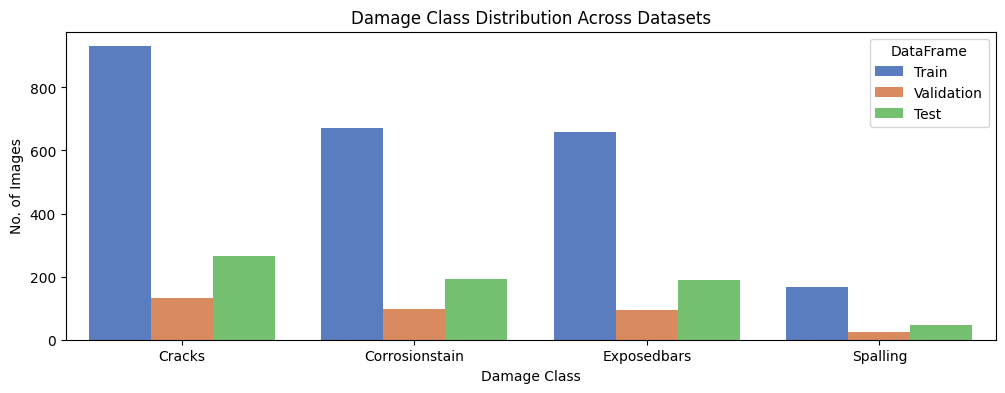

In [24]:
visualize_label_distribution(df_train, df_val, df_test)

Class imbalance is present. This is a problem because the model will be biased towards the majority class. It will be addressed in the experiments.

##### Check image size variety

In [25]:
def visualize_image_size_distribution(img_size_df, tick_interval=200):
    """
    Visualize the distribution of image sizes.

    Parameters:
    - img_size_df (DataFrame): DataFrame containing the image sizes.
    - tick_interval (int): Interval for tick marks on the x-axis.
        
    Returns:
    - None (displays the plot)
    """
    
    # Plotting the distribution
    plt.figure(figsize=(16, 12))
    sns.kdeplot(data=img_size_df, x='Width', y='Height', fill=True, cmap='viridis', thresh=0, levels=20)
    plt.title('Image Size Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')

    plt.xticks(ticks=range(0, int(img_size_df['Width'].max()) + tick_interval, tick_interval))
    plt.yticks(ticks=range(0, int(img_size_df['Height'].max()) + tick_interval, tick_interval))
    plt.grid(True)
    plt.show()

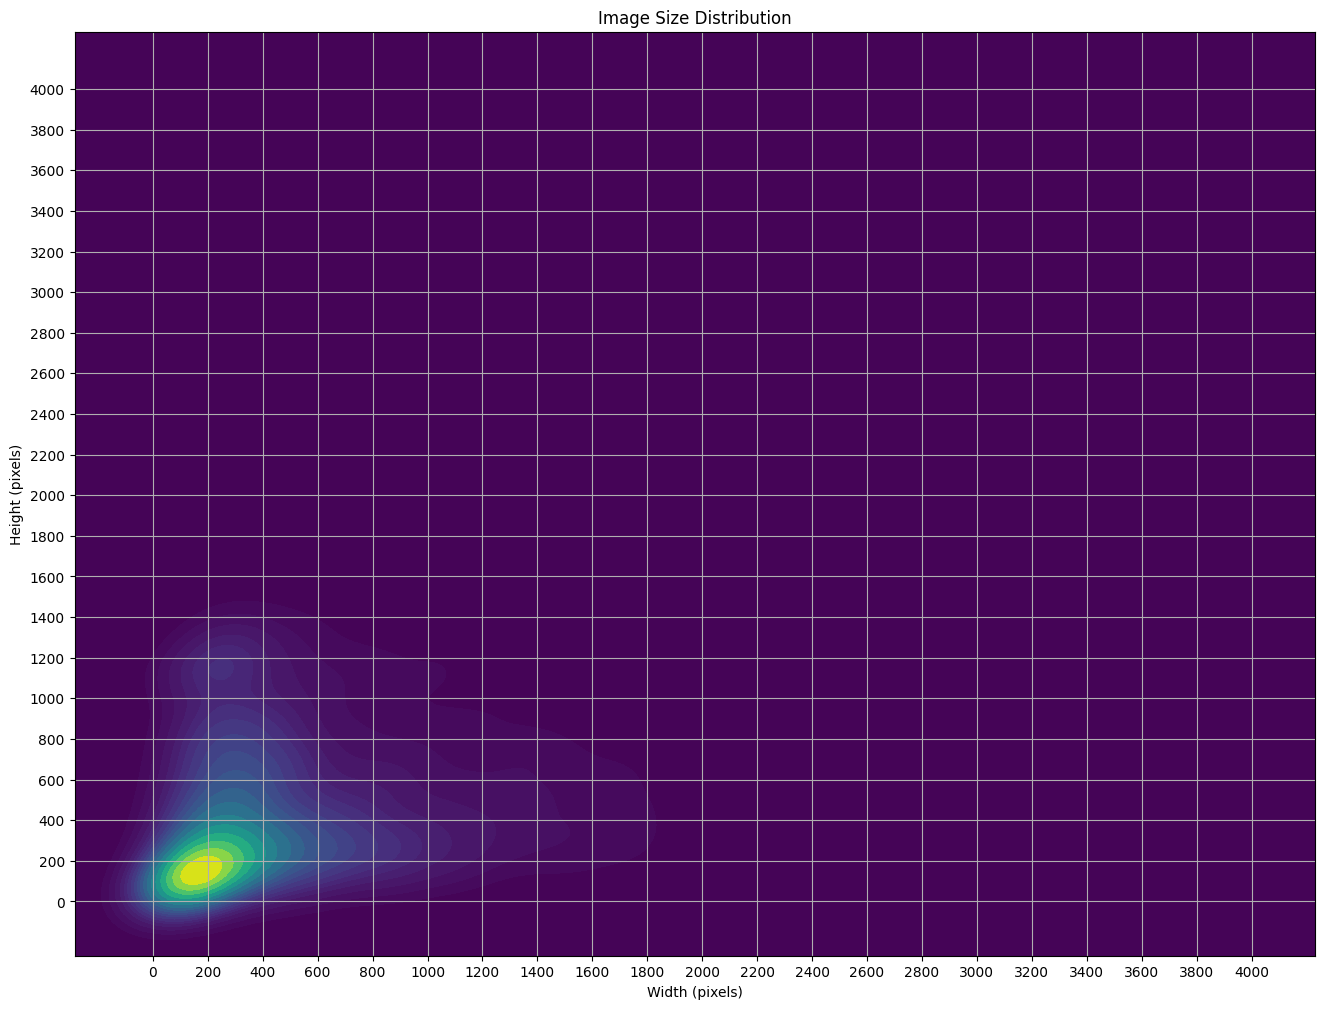

,Width,Height
count,3471.000000,3471.000000
mean,444.431000,438.699798
std,403.524937,388.013361
min,26.000000,32.000000
25%,179.000000,162.000000
50%,308.000000,314.000000
75%,562.500000,611.000000
max,3918.000000,3983.000000


In [27]:
# Create a DataFrame for image sizes
img_size_df = pd.DataFrame(columns=['Width', 'Height'])
img_size_df[['Width', 'Height']] = combined_df['Image Size'].str.split('x', expand=True)

# Convert Width and Height to numeric
img_size_df["Width"] = pd.to_numeric(img_size_df["Width"])
img_size_df["Height"] = pd.to_numeric(img_size_df["Height"])

visualize_image_size_distribution(img_size_df)
img_size_df.describe()

The images vary in sizes, but most images seem to be at around 200x200 pixels.

### Create Generators

In [29]:
# Generator that scales images to 1/255
scale_gen = ImageDataGenerator(
    rescale=1.0/255,
)

In [30]:
train_generator = scale_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = scale_gen.flow_from_directory(
    VAL_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = scale_gen.flow_from_directory(
    TEST_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2428 images belonging to 4 classes.
Found 347 images belonging to 4 classes.
Found 696 images belonging to 4 classes.


### Display sample images

In [31]:
def plot_sample_images(generator, class_labels):
    """
    Plot a sample of images from the generator.

    Parameters:
    - generator (keras.preprocessing.image.ImageDataGenerator): Image data generator.
    - class_labels (list): List of class labels.
        
    Returns:
    - None (displays the plot)
    """
    
    # Get a batch of images and labels from the generator
    images, labels = next(generator)
    
    # Plot the images
    plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

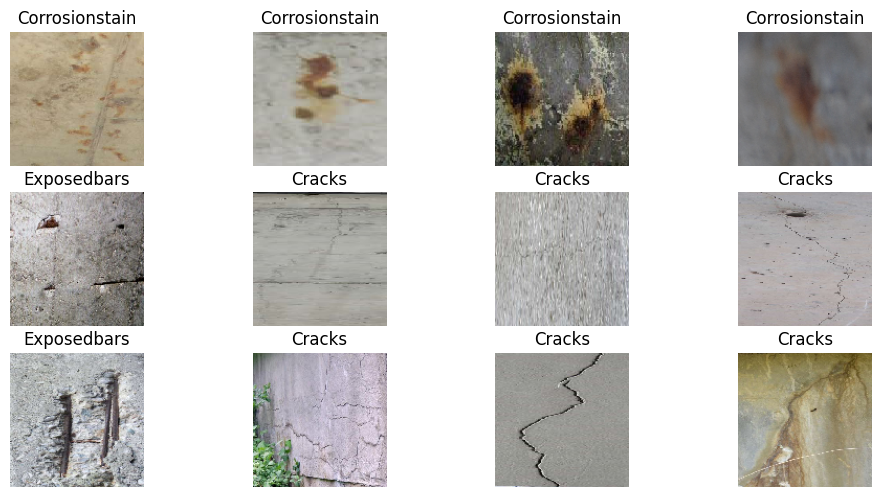

In [32]:
class_labels = list(train_generator.class_indices.keys())
plot_sample_images(train_generator, class_labels)

The images are being displayed properly.